In [1]:
%autoreload 2
from plasmapy import simulation
import astropy.units as u
import numpy as np

In [2]:
import xarray

In [3]:
from plasmapy.classes.sources.interparticle import InterParticleForces

In [4]:
eq_distance = 0.1
forces = {key: InterParticleForces(key, 100, eq_distance, 1, 100000, 4) for key in ('python', 'njit', 'njit_parallel')}

from collections import namedtuple
CustomParticle = namedtuple('custom_particle', ['mass', 'charge'])
particle = CustomParticle(mass=1 * u.dimensionless_unscaled, charge=1 * u.dimensionless_unscaled)

L = 1 * u.m
N = 100
x = u.Quantity(np.random.random((N, 3))*L,  u.m)
v = u.Quantity(np.zeros(x.shape, dtype=float), u.m / u.s)

solutions = {engine: simulation.ParticleTracker(forces[engine], x, v, particle).run(1e-3 * u.s, dt = 1e-8 * u.s) for engine in ['njit']}

In [28]:

    [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]

[(-1, -2),
 (0, -2),
 (1, -2),
 (-2, -1),
 (-1, -1),
 (0, -1),
 (1, -1),
 (2, -1),
 (-2, 0),
 (-1, 0),
 (1, 0),
 (2, 0),
 (-2, 1),
 (-1, 1),
 (0, 1),
 (1, 1),
 (2, 1),
 (-1, 2),
 (0, 2),
 (1, 2),
 (0, 0)]

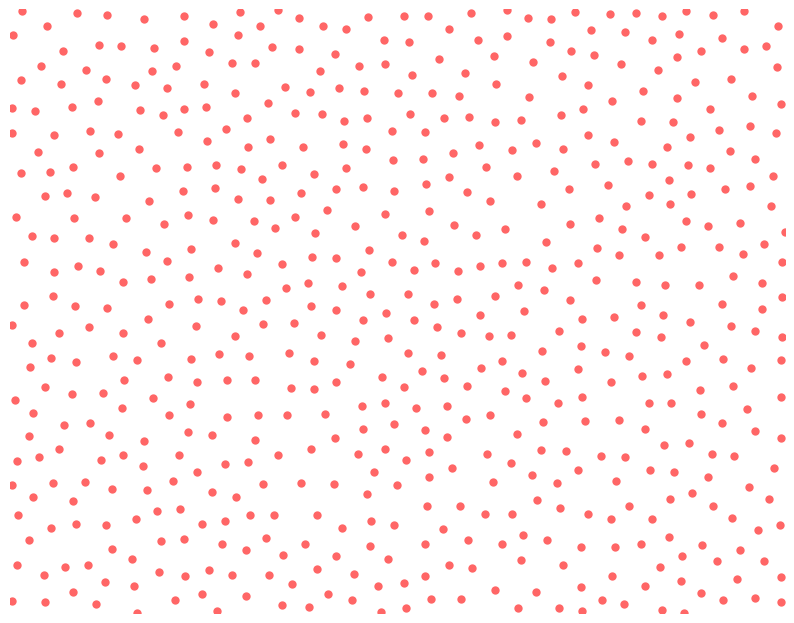

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Choose up to k points around each reference point as candidates for a new
# sample point
k = 30

# Minimum distance between samples
r = 2 * eq_distance

width, height = L, 45

# Cell side length
a = r/np.sqrt(3)
# Number of cells in the x- and y-directions of the grid
nx, ny, nz = int(L / a) + 1, int(L / a) + 1, int(L / a) + 1

# A list of coordinates in the grid of cells
coords_list = [(ix, iy,iz) for ix in range(nx) for iy in range(ny) for iz in range(nz)]
# Initilalize the dictionary of cells: each key is a cell's coordinates, the
# corresponding value is the index of that cell's point's coordinates in the
# samples list (or None if the cell is empty).
cells = {coords: None for coords in coords_list}

def get_cell_coords(pt):
    """Get the coordinates of the cell that pt = (x,y) falls in."""

    return int(pt[0] // a), int(pt[1] // a), int(pt[2] // a)

def get_neighbours(coords):
    """Return the indexes of points in cells neighbouring cell at coords.

    For the cell at coords = (x,y), return the indexes of points in the cells
    with neighbouring coordinates illustrated below: ie those cells that could 
    contain points closer than r.

                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo

    """

    # TODO
    dxdy = [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx and
                0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            # This cell is occupied: store this index of the contained point.
            neighbours.append(neighbour_cell)
    return neighbours

def point_valid(pt):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """

    cell_coords = get_cell_coords(pt)
    for idx in get_neighbours(cell_coords):
        nearby_pt = samples[idx]
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0]-pt[0])**2 + (nearby_pt[1]-pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True

def get_point(k, refpt):
    """Try to find a candidate point relative to refpt to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    while i < k:
        rho, theta = np.random.uniform(r, 2*r), np.random.uniform(0, 2*np.pi)
        pt = refpt[0] + rho*np.cos(theta), refpt[1] + rho*np.sin(theta)
        if not (0 <= pt[0] < width and 0 <= pt[1] < height):
            # This point falls outside the domain, so try again.
            continue
        if point_valid(pt):
            return pt
        i += 1
    # We failed to find a suitable point in the vicinity of refpt.
    return False

# Pick a random point to start with.
pt = (np.random.uniform(0, L), np.random.uniform(0, L), np.random.uniform(0, L))
samples = [pt]
# Our first sample is indexed at 0 in the samples list...
cells[get_cell_coords(pt)] = 0
# ... and it is active, in the sense that we're going to look for more points
# in its neighbourhood.
active = [0]

nsamples = 1
# As long as there are points in the active list, keep trying to find samples.
while active:
    # choose a random "reference" point from the active list.
    idx = np.random.choice(active)
    refpt = samples[idx]
    # Try to pick a new point relative to the reference point.
    pt = get_point(k, refpt)
    if pt:
        # Point pt is valid: add it to the samples list and mark it as active
        samples.append(pt)
        nsamples += 1
        active.append(len(samples)-1)
        cells[get_cell_coords(pt)] = len(samples) - 1
    else:
        # We had to give up looking for valid points near refpt, so remove it
        # from the list of "active" points.
        active.remove(idx)

plt.scatter(*zip(*samples), color='r', alpha=0.6, lw=0)
plt.xlim(0, width)
plt.ylim(0, height)
plt.axis('off')
plt.show()

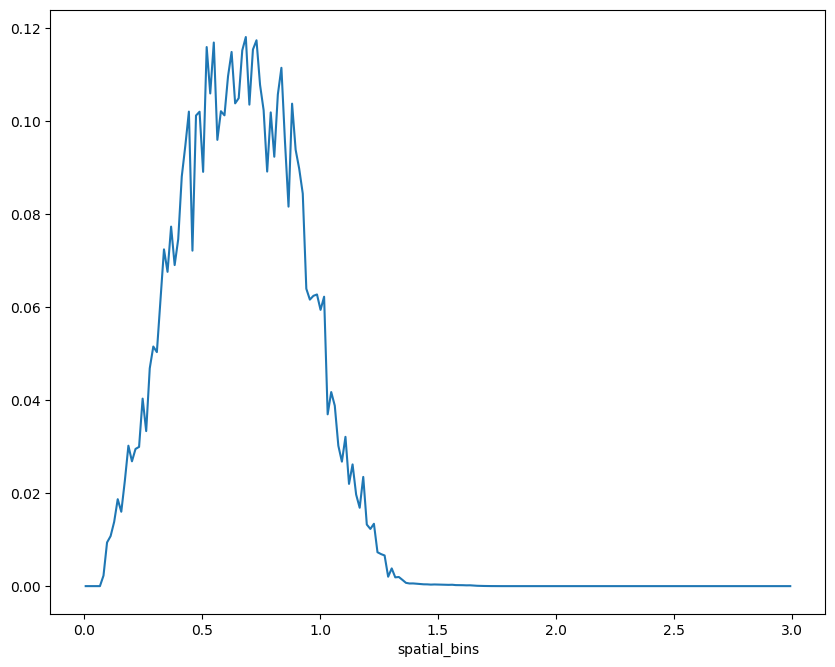

In [5]:
N_bins = 200
N_times = 1000
for solution in solutions.values():
    density = N / L ** 3

    from scipy import spatial

    import tqdm.auto as tqdm

    all_histograms = []
#     max_L = L * 3**0.5
    max_L = L * 3
    bins, dx = np.linspace(0, max_L, N_bins, endpoint=True, retstep=True)
    our_times = solution.time[np.linspace(0, solution.time.size, N_times, endpoint=False, dtype=int)]
    spatial_bins = (bins[1:] + bins[:-1] )/2
    for time in tqdm.tqdm(our_times):
        pos = solution.position.sel(time=time)
        tree = spatial.cKDTree(pos)

        histograms = []
        for particle in range(N):
            distances, indices = tree.query(pos.sel(particle=particle), range(2, N))
            hist, final_bins = np.histogram(distances, bins)
            rdf = hist / (4 * np.pi * dx * density)
            histograms.append(rdf)
        all_histograms.append(histograms)


    
    da = xarray.DataArray(all_histograms,
                          dims=('time', 'particle', 'spatial_bins'),
                          coords = {'time': our_times, 'spatial_bins': spatial_bins, 'particle': solution.particle})
#     solution.coords['spatial_bins'] = spatial_bins

#     solution['rdf'] = (('time', 'particle', 'spatial_bins'), np.array(all_histograms))

#     solution.rdf.mean(dim='particle').isel(time=-3).plot.line()

da.isel(time=range(50, 100)).mean(dim=['particle', 'time']).plot.line()

In [23]:
np.array(all_histograms).shape

(100, 30, 99)

In [ ]:
da

KeyboardInterrupt: 

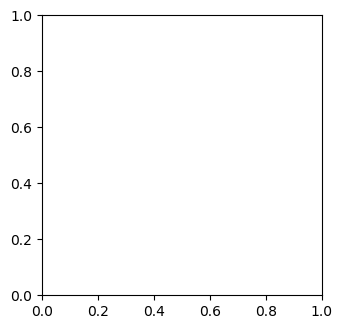

In [126]:
hv.Dataset(solution.isel(time=range(100))).to(hv.Image, ['spatial_bins'])

In [120]:
import xarray as xr
import holoviews as hv
hv.extension('matplotlib')

air = xr.tutorial.open_dataset('air_temperature').load()
ds = hv.Dataset(air.isel(time=range(100)))
images = ds.to(hv.Image, ['lon', 'lat']).options(fig_inches=(10, 5), colorbar=True, cmap='viridis')
hv.save(images, 'hv_anim.mp4', fps=4)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W


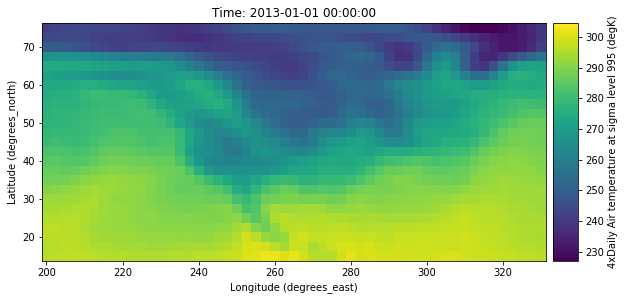
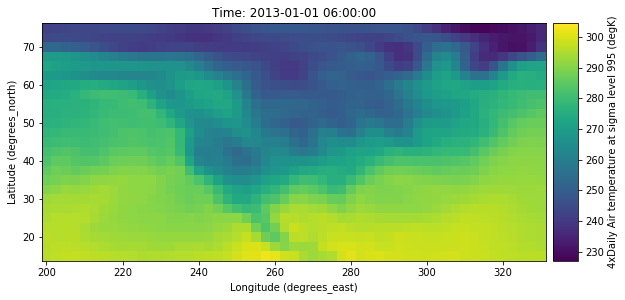
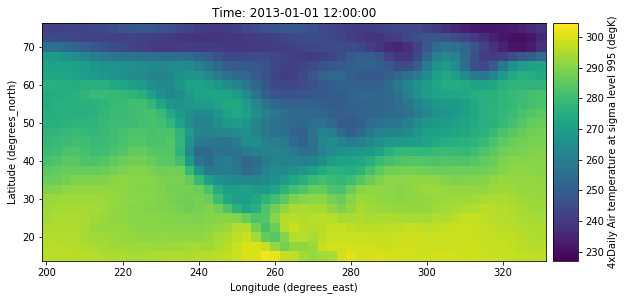
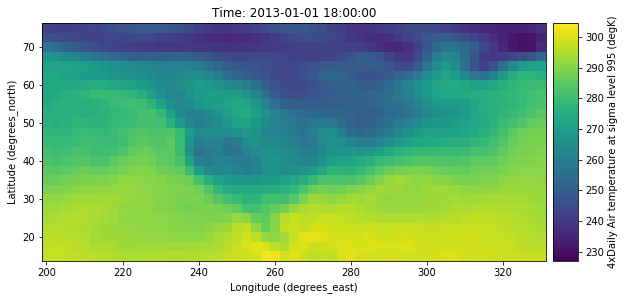
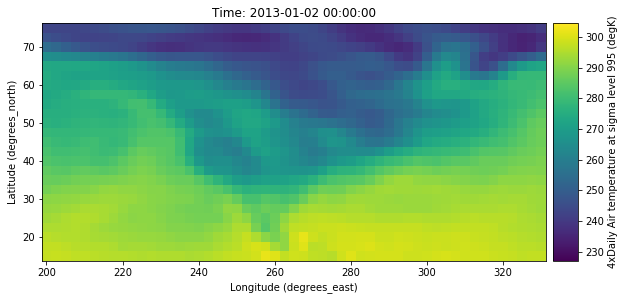
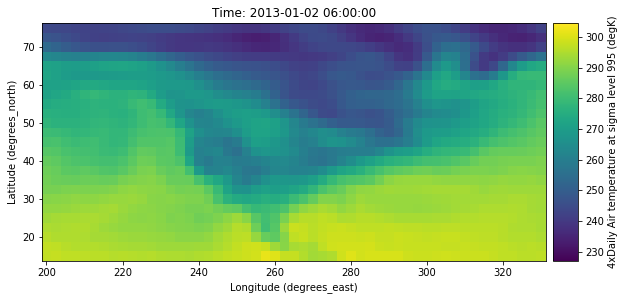
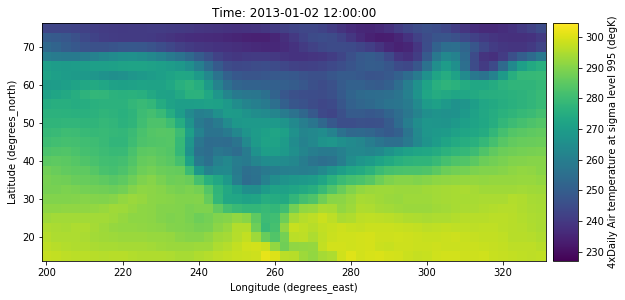
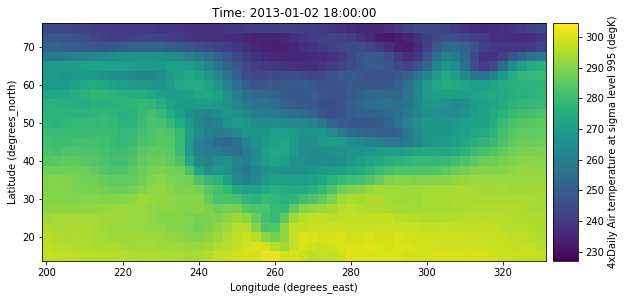
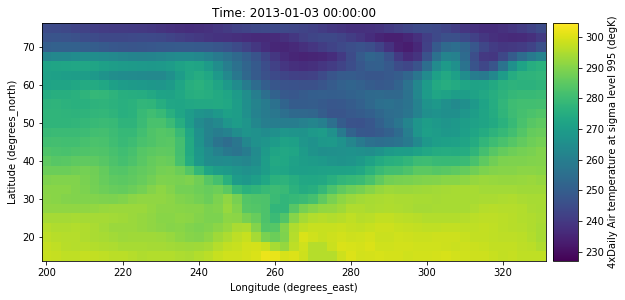
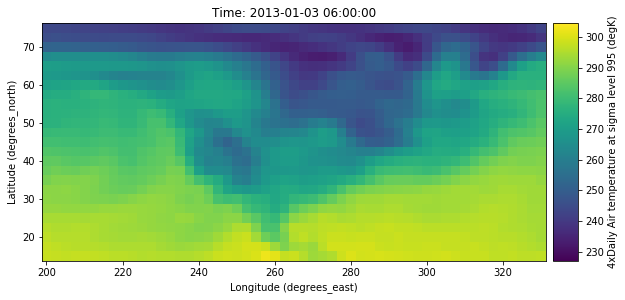
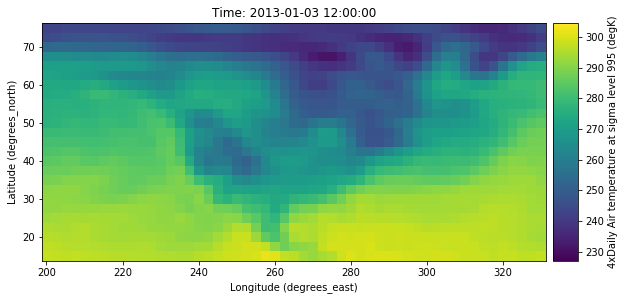
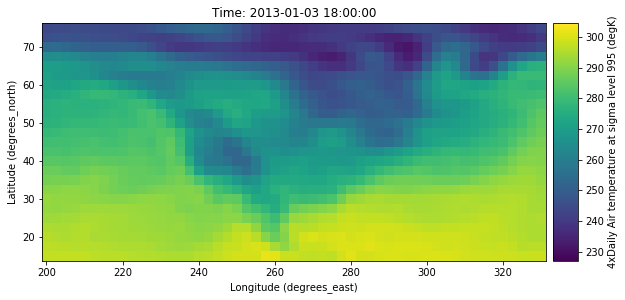
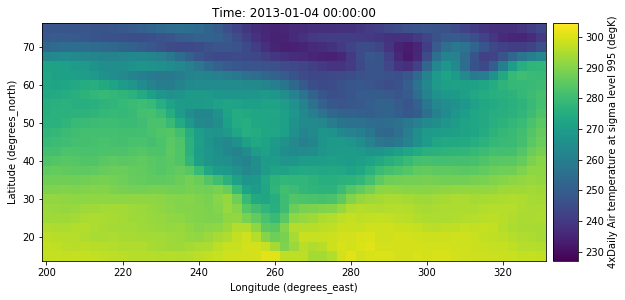
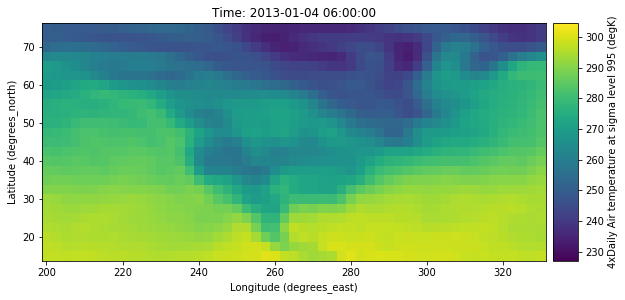
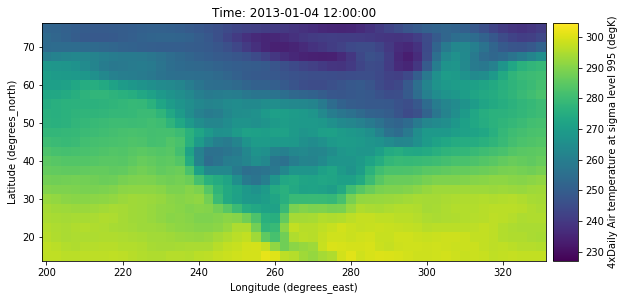
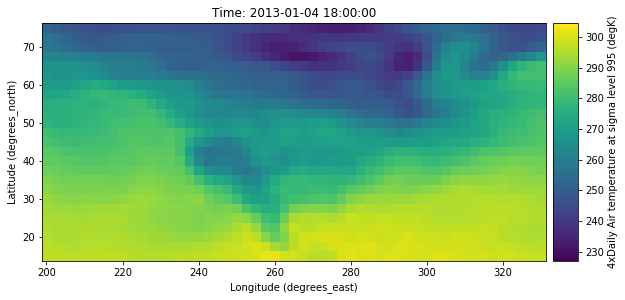
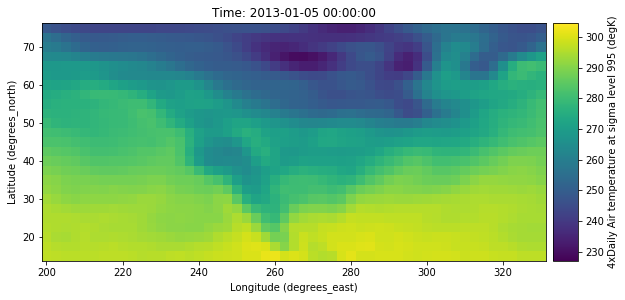
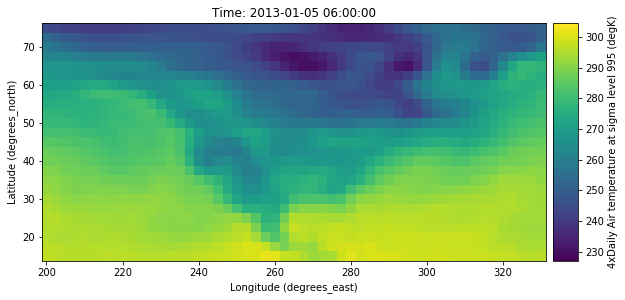
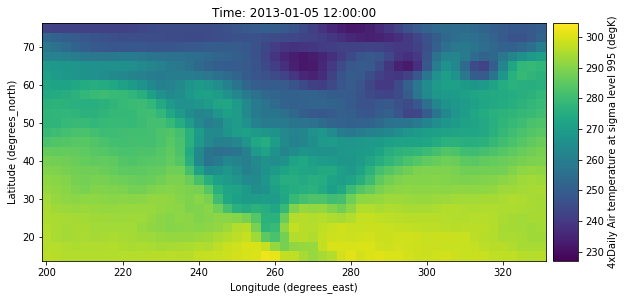
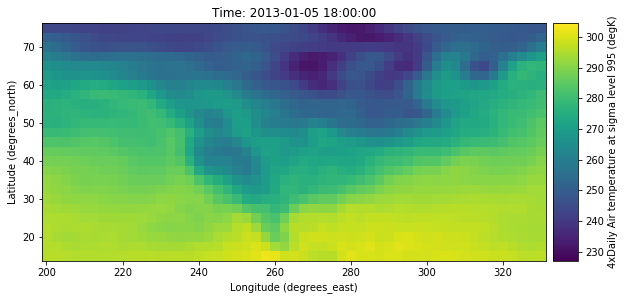
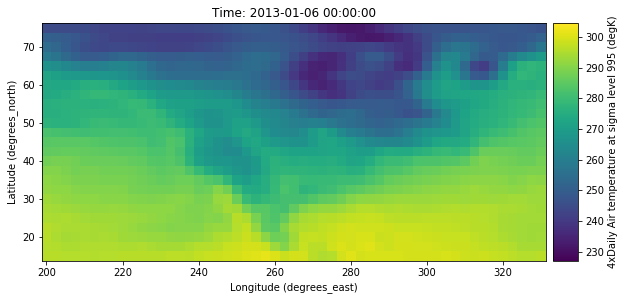
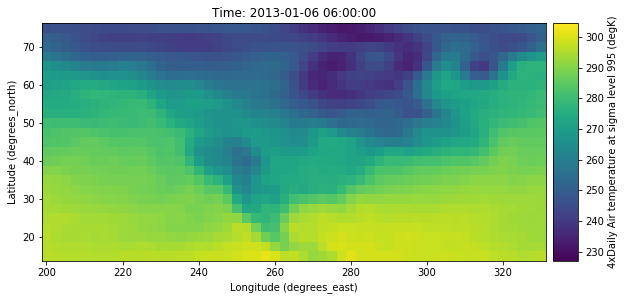
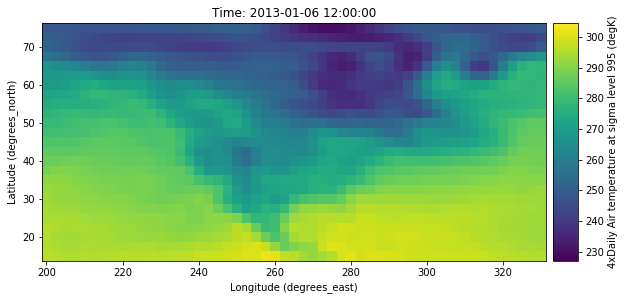
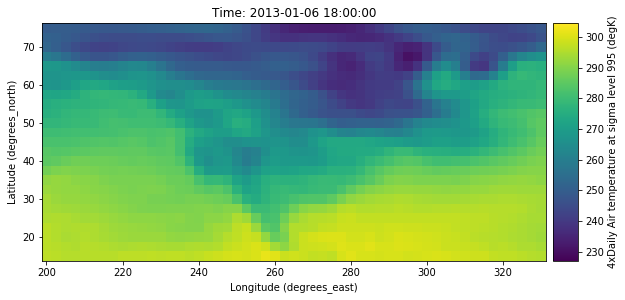
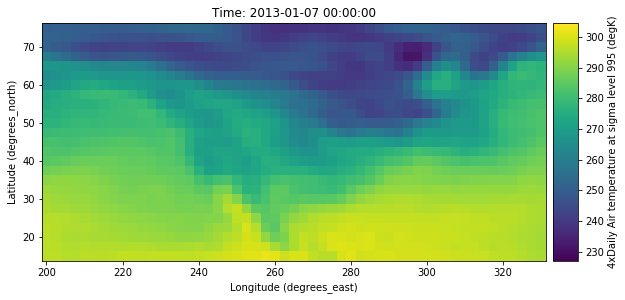
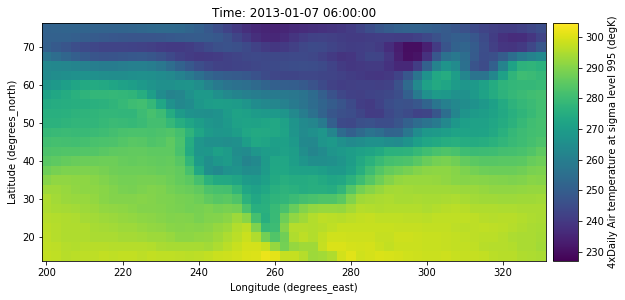
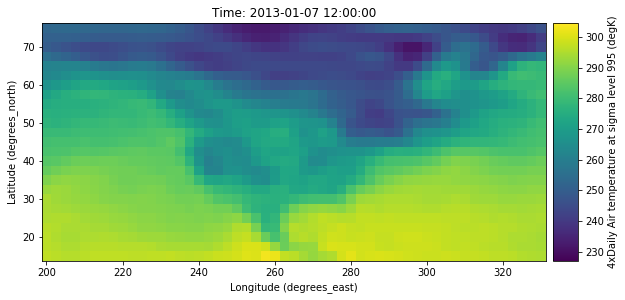
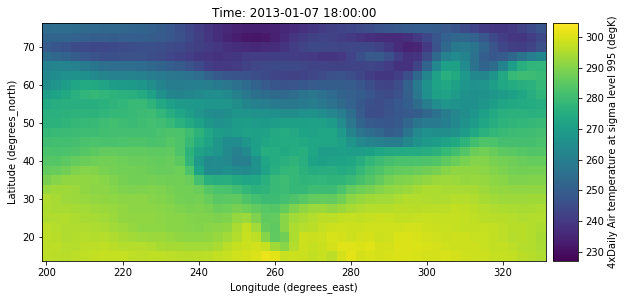
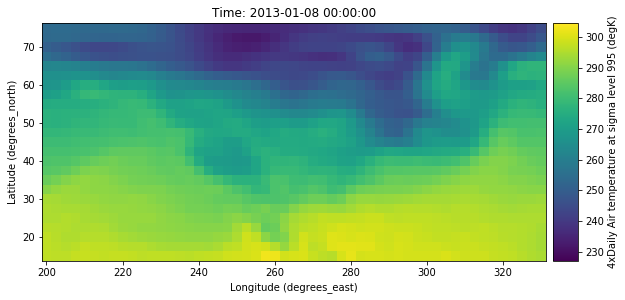
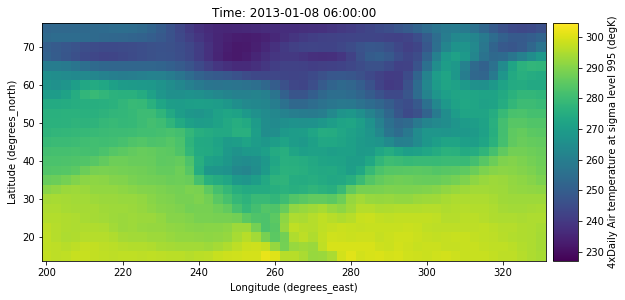
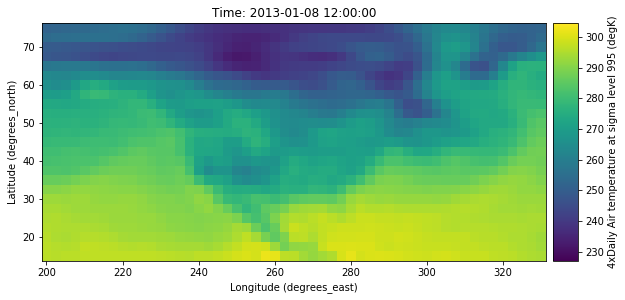
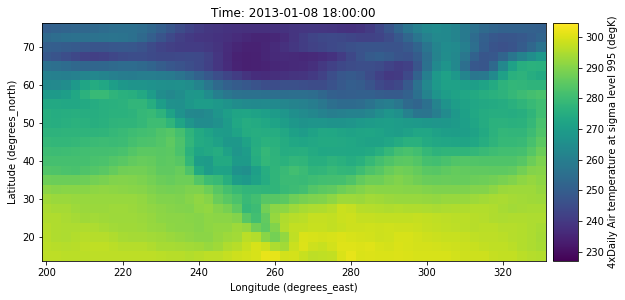
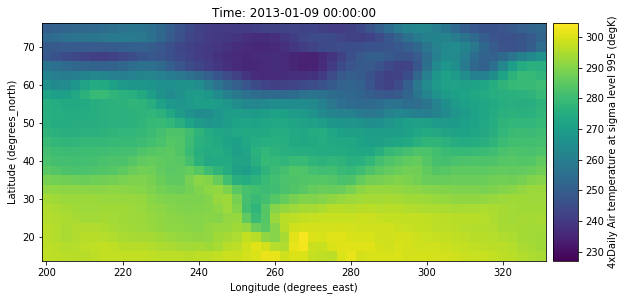
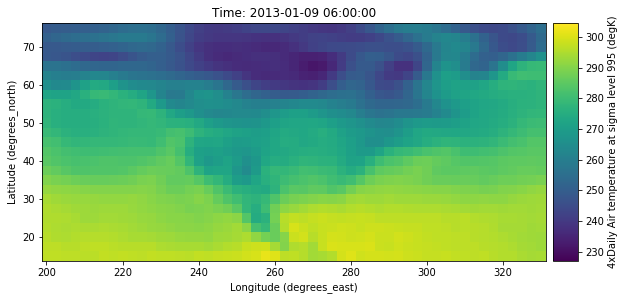
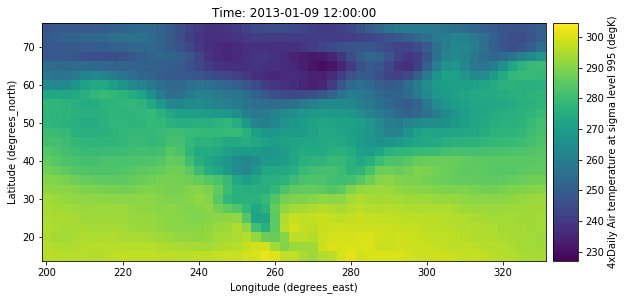
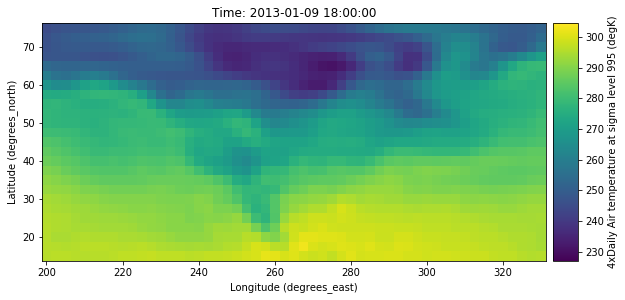
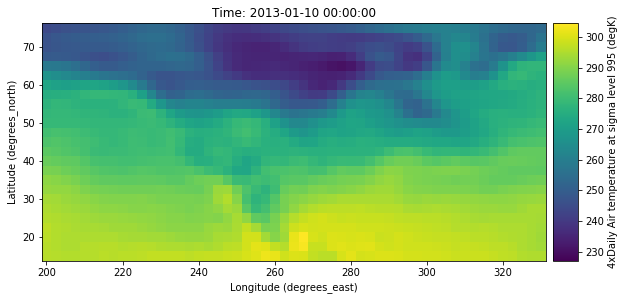
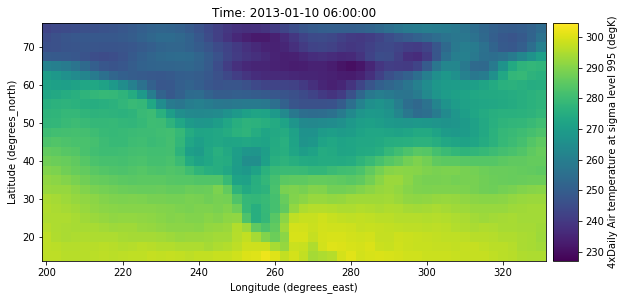
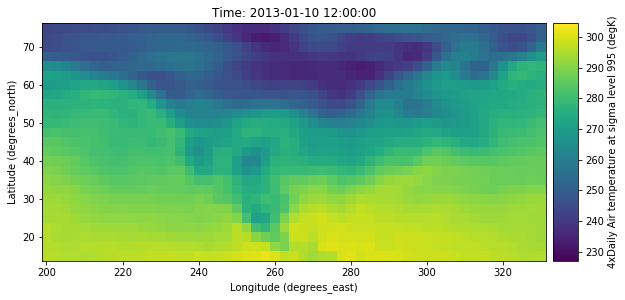
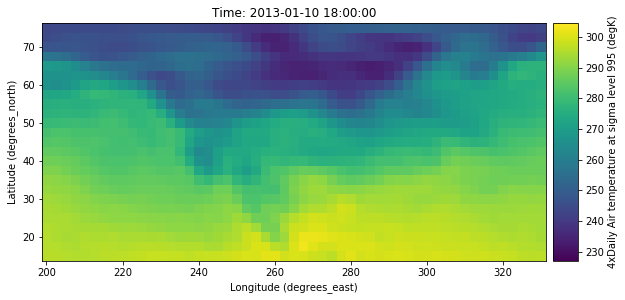
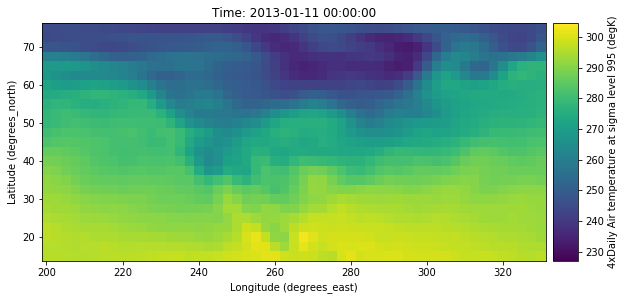
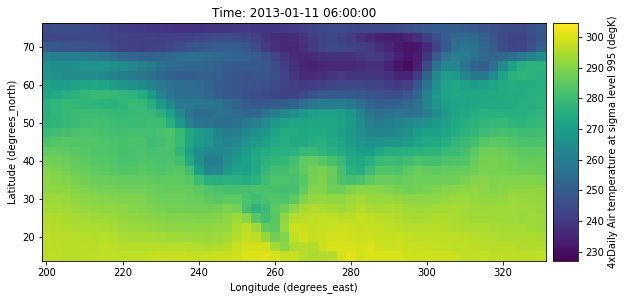
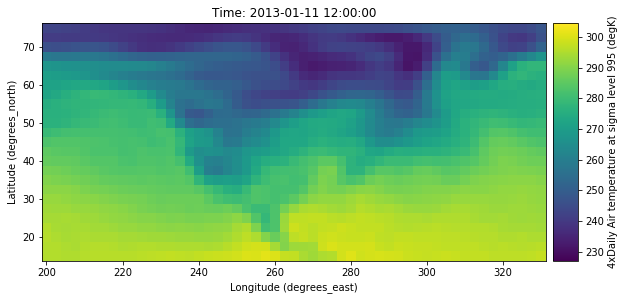
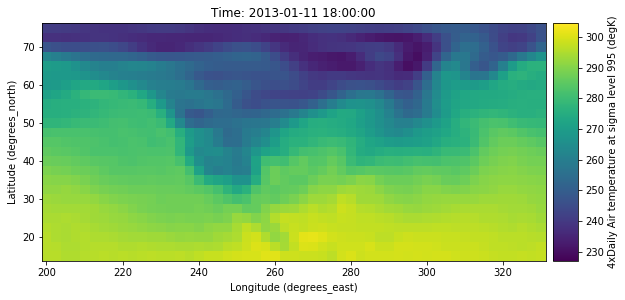
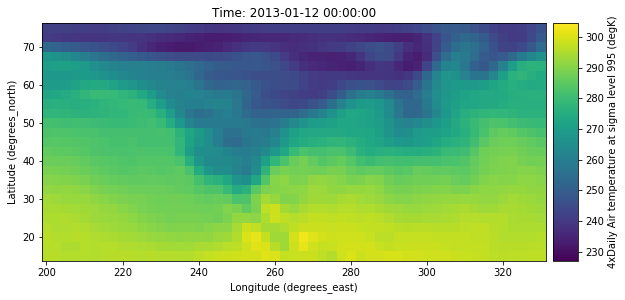
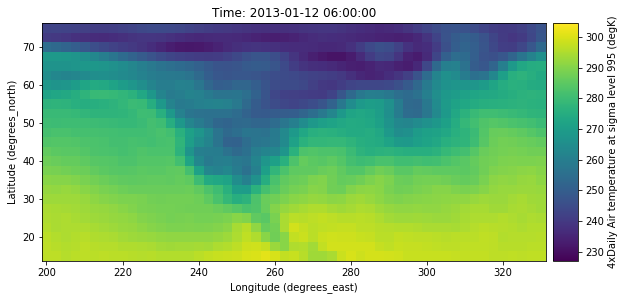
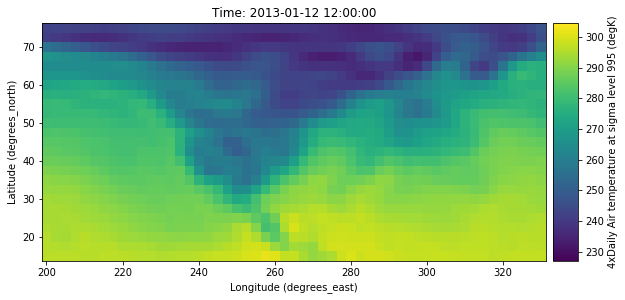
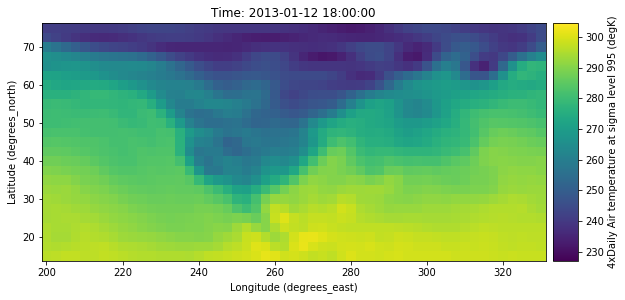
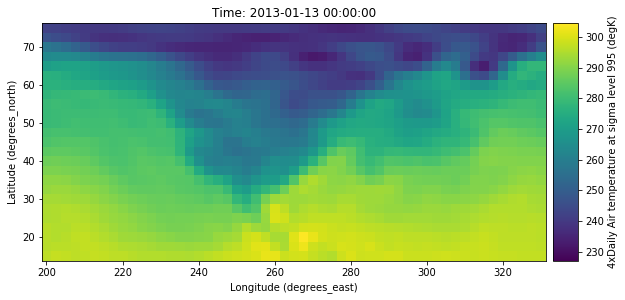
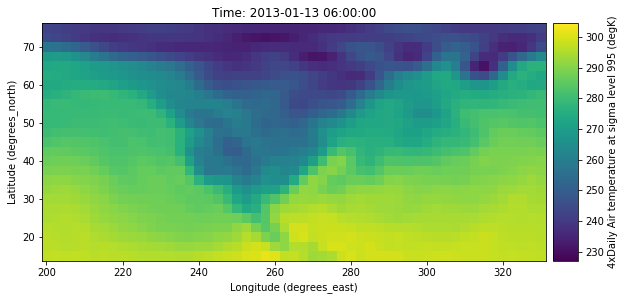
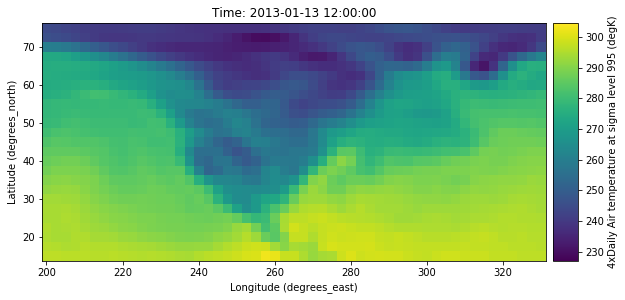
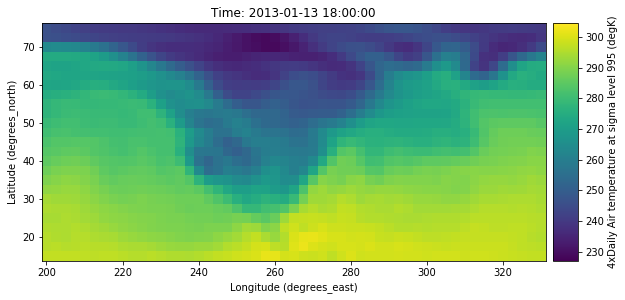
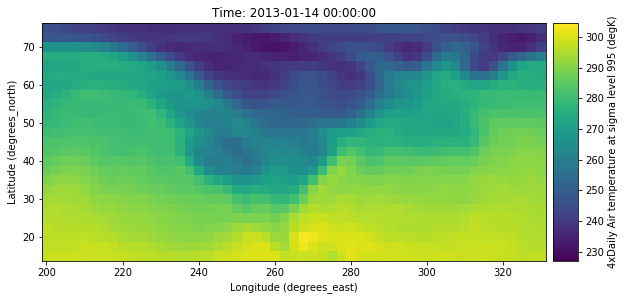
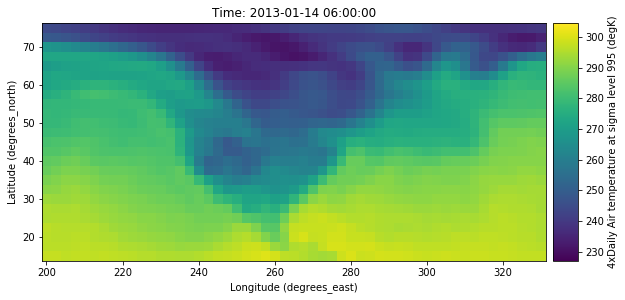
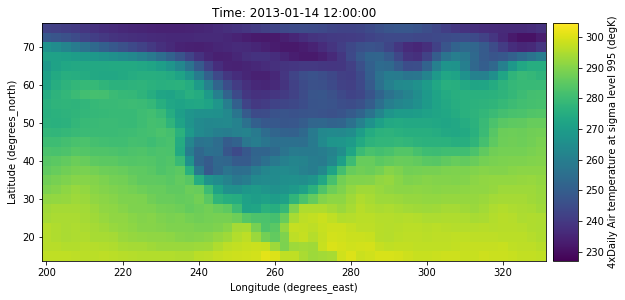
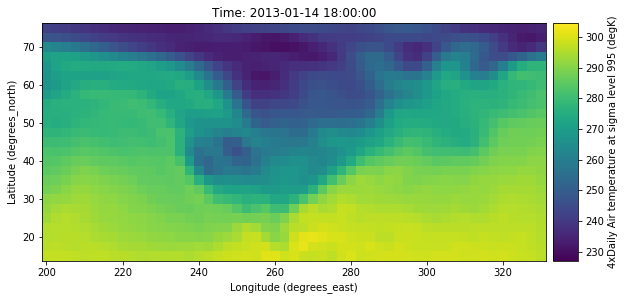
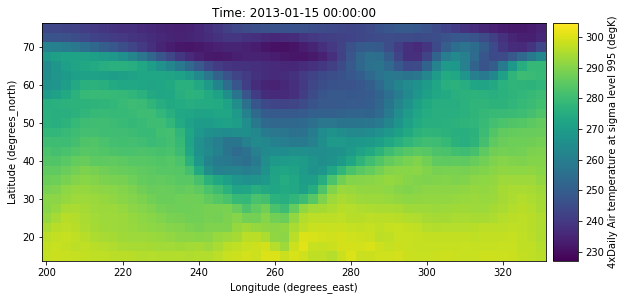
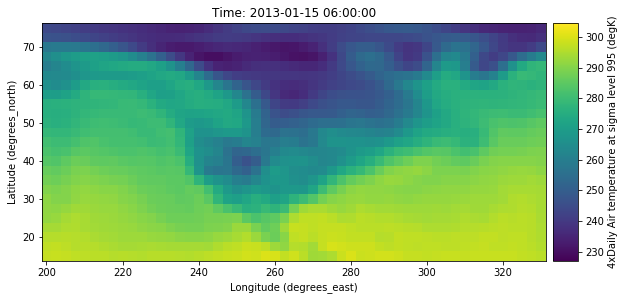
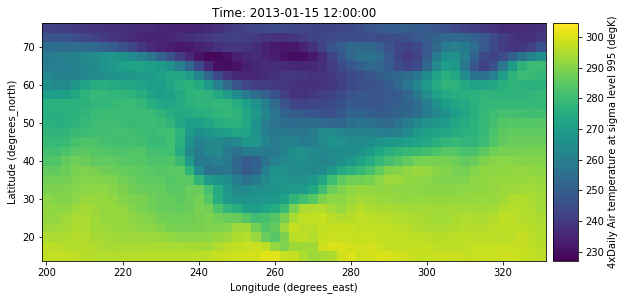
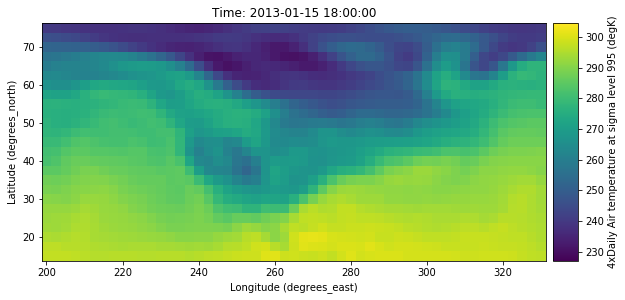
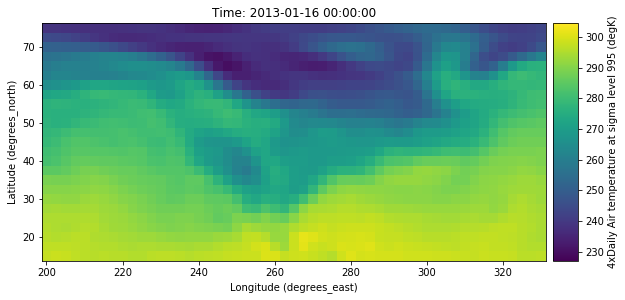
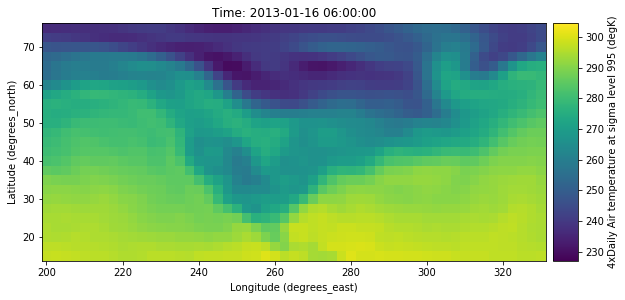
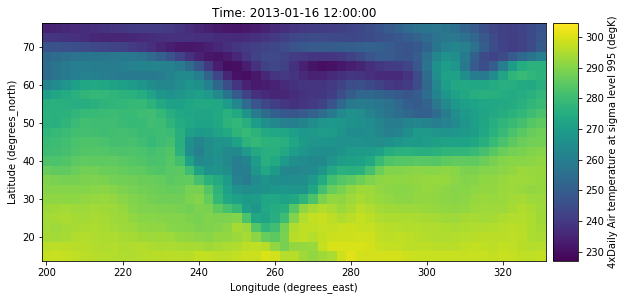
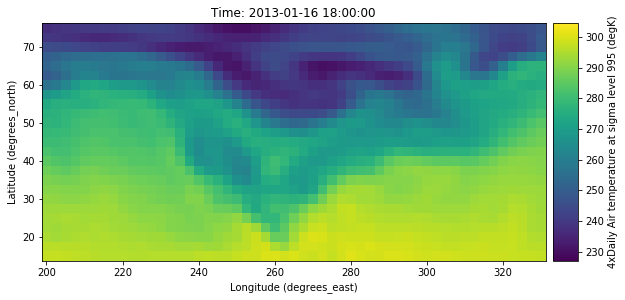
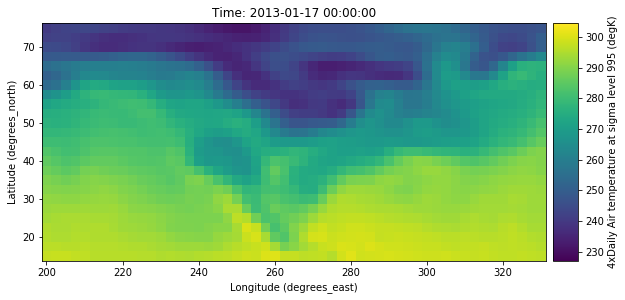
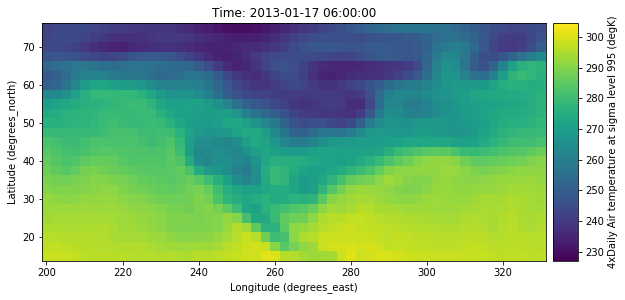
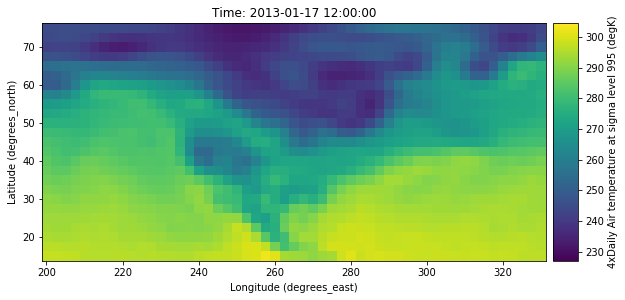
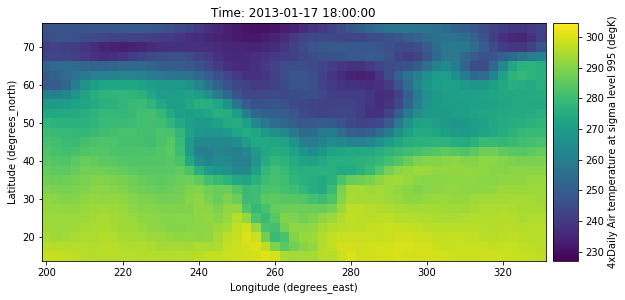
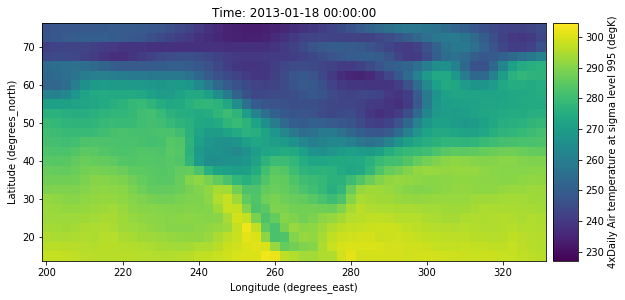
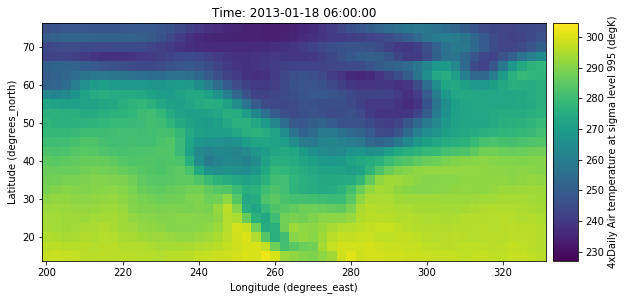
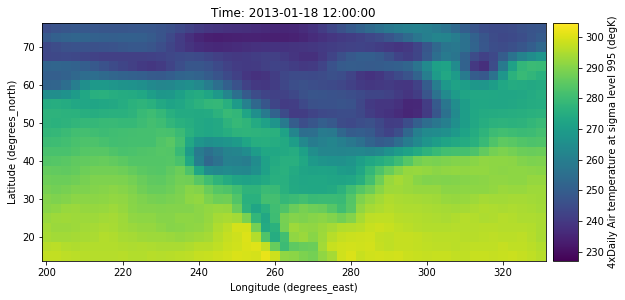
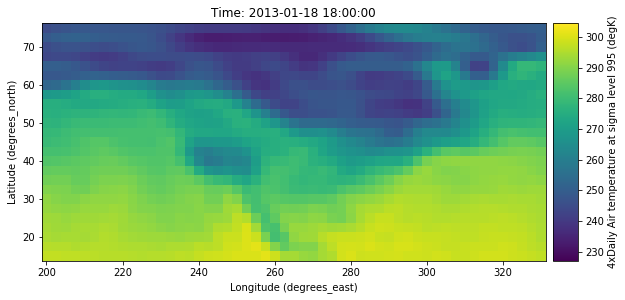
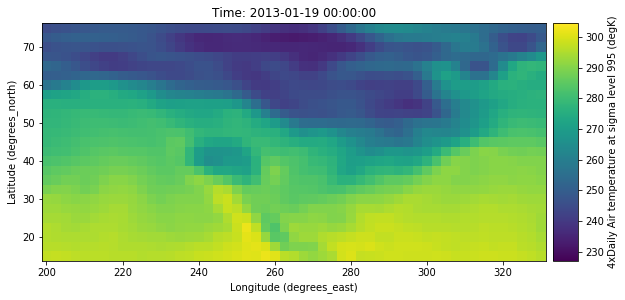
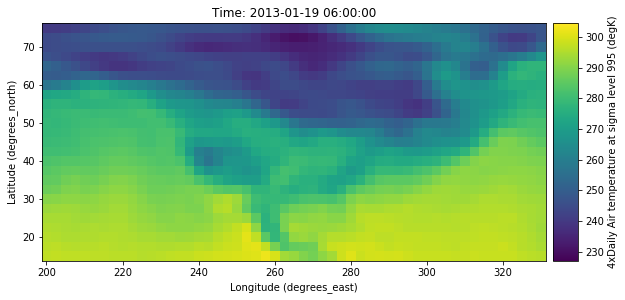
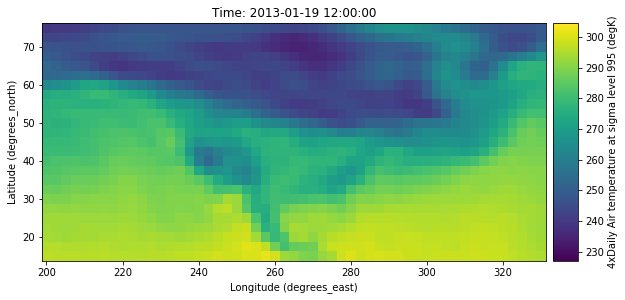
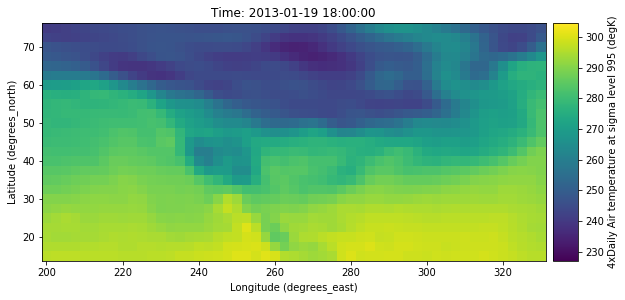
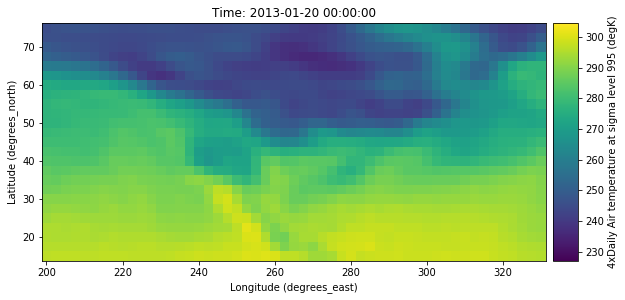
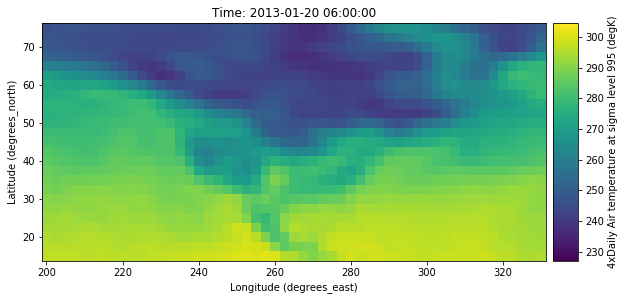
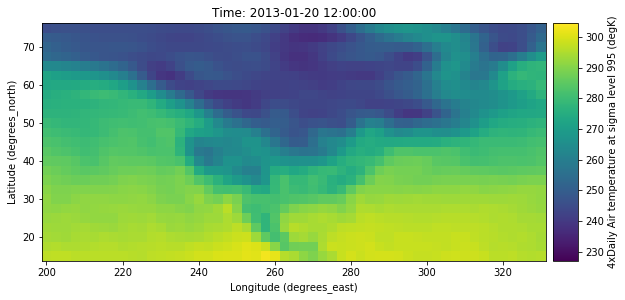
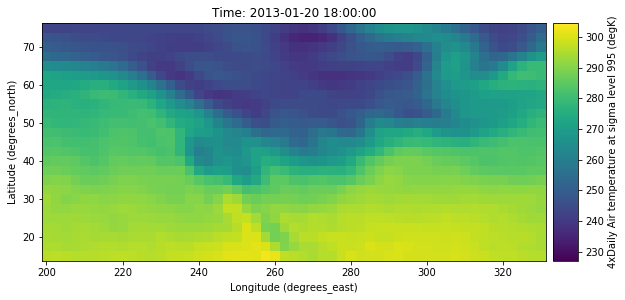
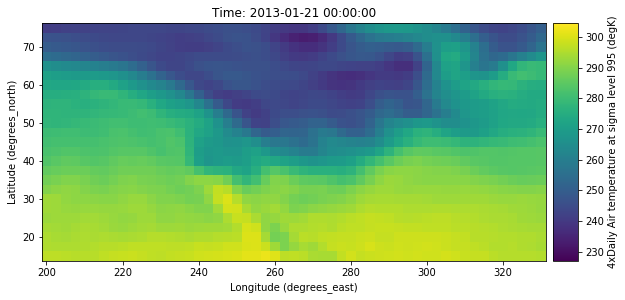
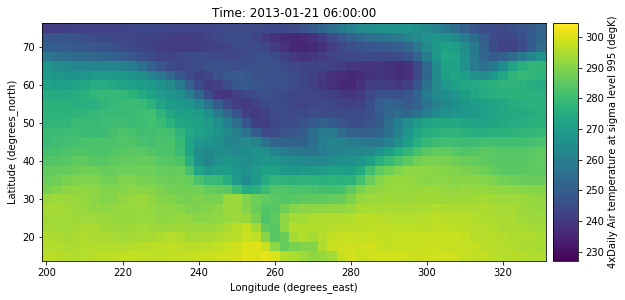
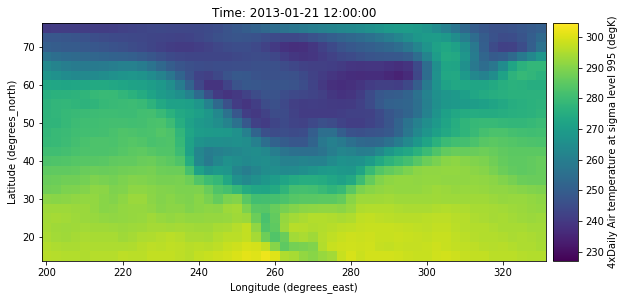
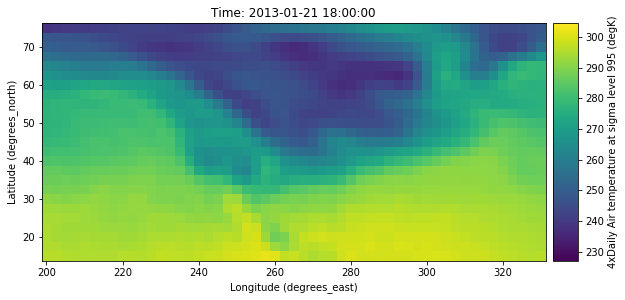
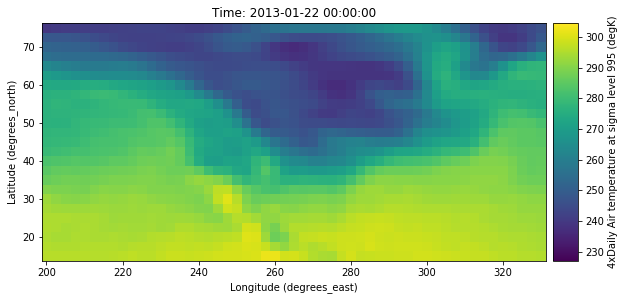
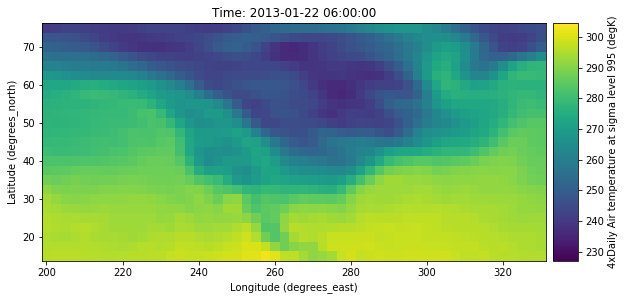
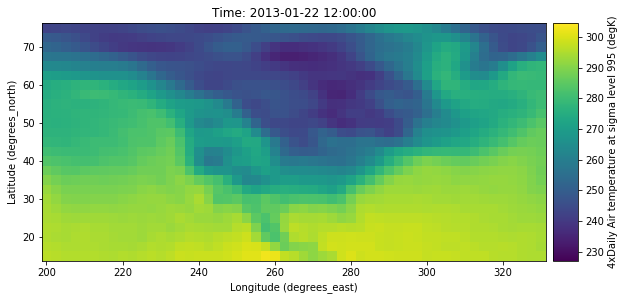
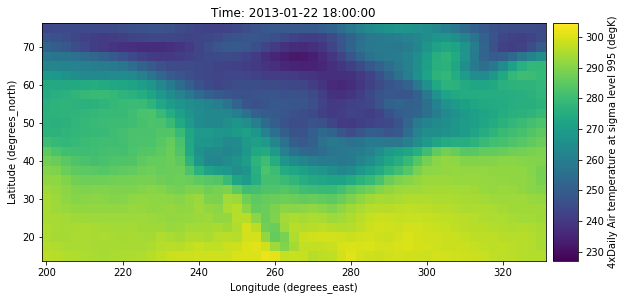
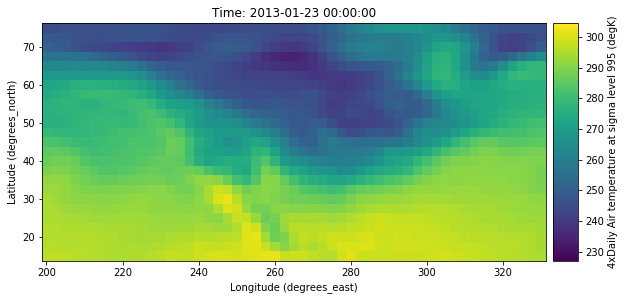
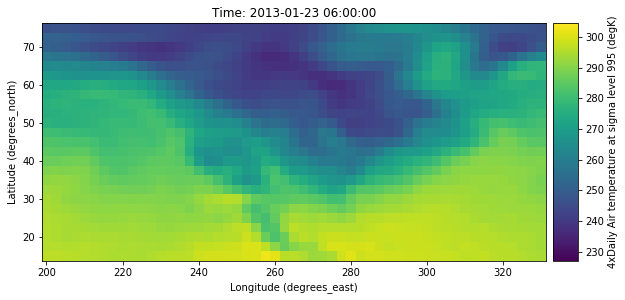
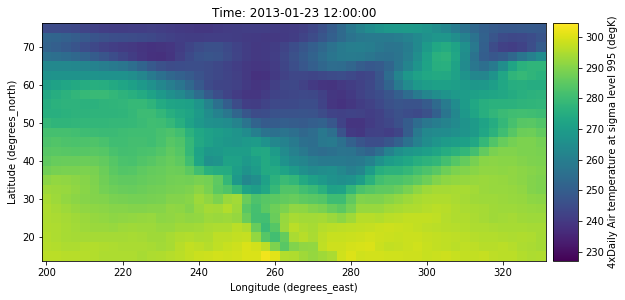
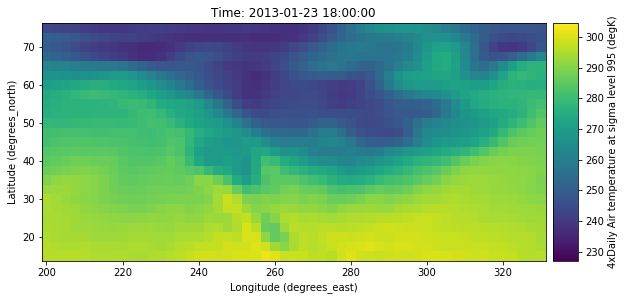
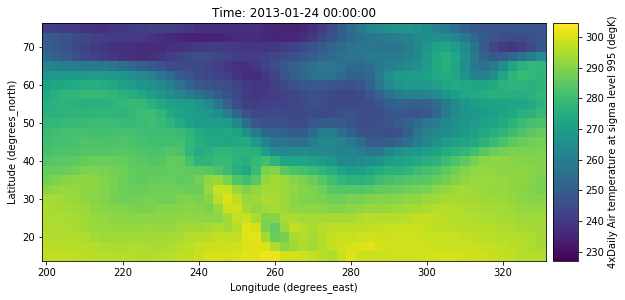
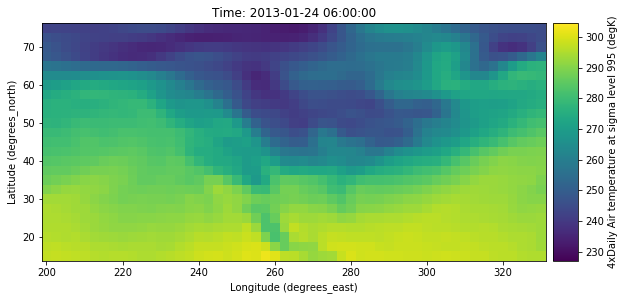
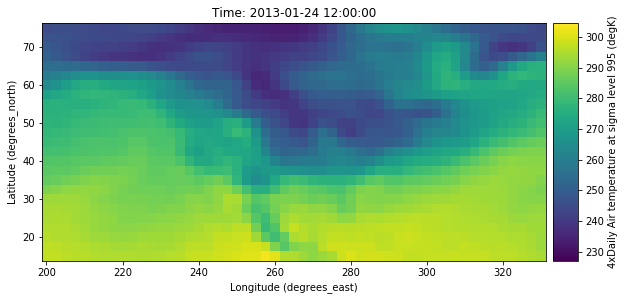
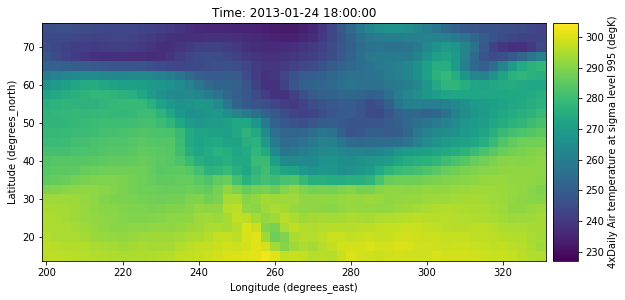
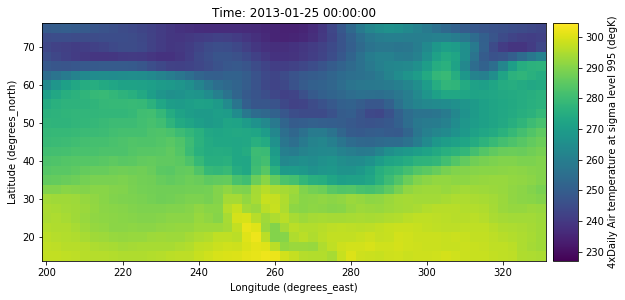
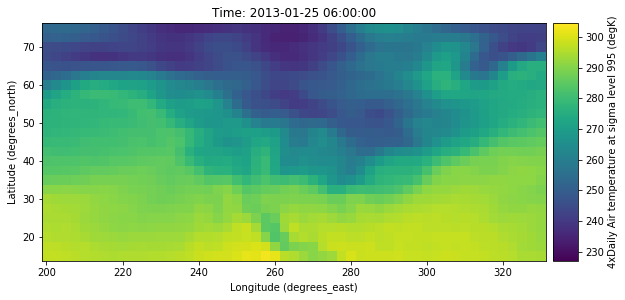
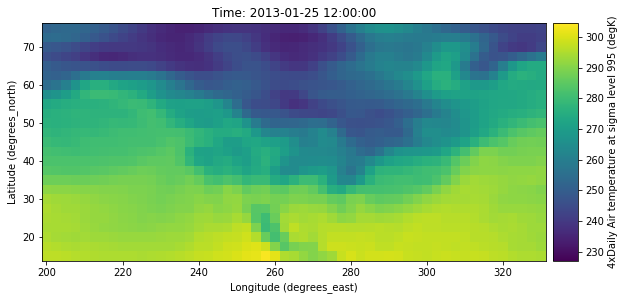
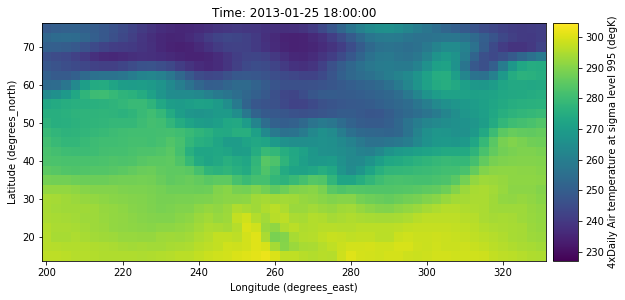

In [122]:
hv.save(images, 'anim.html', fmt='scrubber')

# ---

from IPython.core.display import display, HTML
display(HTML('anim.html'))

In [18]:
solution.position.isel(time=0)

<xarray.DataArray 'position' (particle: 5, dimension: 3)>
array([[0.57701953, 0.63017187, 0.05451382],
       [0.7846927 , 0.84897478, 0.37009617],
       [0.85192402, 0.10453229, 0.24830356],
       [0.46805144, 0.77297637, 0.45769324],
       [0.17050476, 0.11958369, 0.33686446]])
Coordinates:
    time       float64 0.0
  * particle   (particle) int64 0 1 2 3 4
  * dimension  (dimension) <U1 'x' 'y' 'z'
Attributes:
    unit:     m

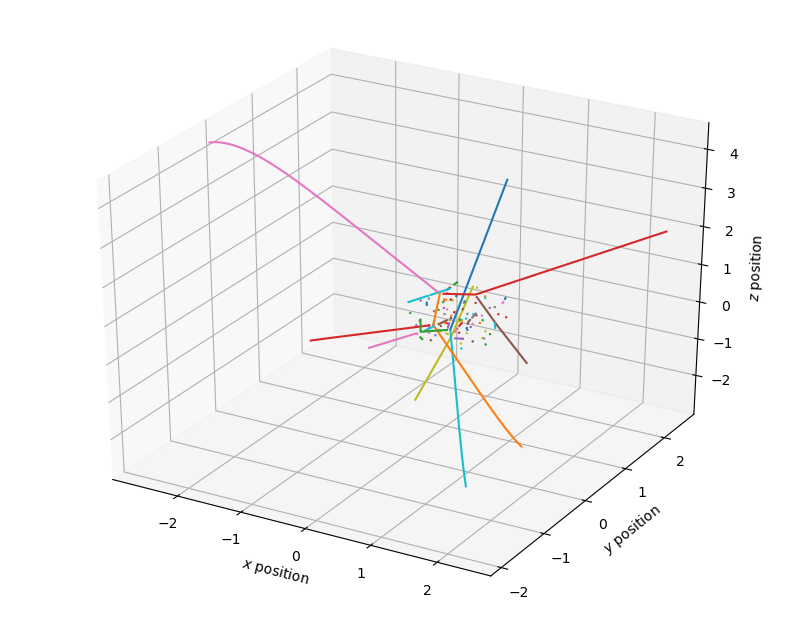

In [6]:
solution.particletracker.plot_trajectories()

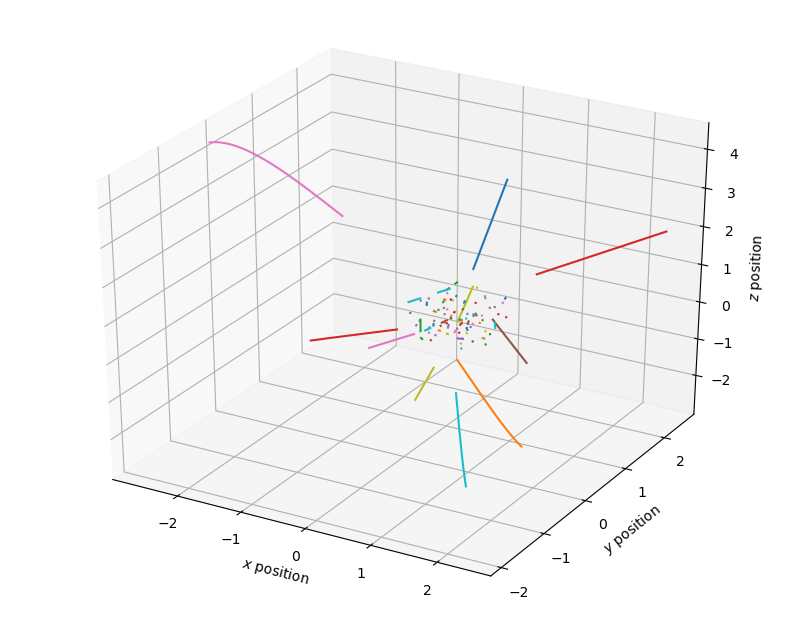

In [26]:
solution.isel(time=range(solution.time.size//10 * 4, solution.time.size // 10 * 10)).particletracker.plot_trajectories()

In [7]:
solution.particletracker.plot_time_trajectories('x')

KeyboardInterrupt: 

In [47]:
solutions

{'python': <xarray.Dataset>
 Dimensions:         (dimension: 3, particle: 20, time: 100002)
 Coordinates:
   * time            (time) float64 0.0 1e-05 2e-05 3e-05 ... 1.0 1.0 1.0 1.0
   * particle        (particle) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
   * dimension       (dimension) <U1 'x' 'y' 'z'
 Data variables:
     position        (time, particle, dimension) float64 0.9267 0.8834 ... 37.82
     velocity        (time, particle, dimension) float64 -2.122 ... -1.739e+04
     B               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
     E               (time, particle, dimension) float64 4.243e+05 ... -1.873e+08
     timestep        (time) float64 1e-05 1e-05 1e-05 1e-05 ... 1e-05 1e-05 1e-05
     kinetic_energy  (time, particle) float64 3.039 1.531e+12 ... 7.878e+11
 Attributes:
     particle:  custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>),
 'njit': <xarray.Dataset>
 Dimensions:         (dimension: 3, particle: 20, time: 100002)
 Coordina

In [48]:
solution = solutions['python']
import pyvista
fig = pyvista.PlotterITK()
for particle in range(N):
    solution.particletracker.visualize(fig, particle=particle, stride=10);
fig.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…